## Unit 2 Build
### Results Analysis

I should have had all this in one file, but felt things were getting cluttered. So I recreated the modeling phase without the bulky search section. All analysis is at the end of this file.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/bsmrvl/DS-Unit-2-Applied-Modeling/tree/master/data/'
    !pip install category_encoders==2.*

else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
np.random.seed = 42
import matplotlib.pyplot as plt

from category_encoders import OrdinalEncoder
from scipy.stats import uniform, truncnorm, randint
from xgboost import XGBClassifier
from math import floor

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.inspection import permutation_importance, plot_partial_dependence, partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_score, recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv(DATA_PATH + 'ABIII_English.csv', dtype=object)
AB_demo = pd.read_csv(DATA_PATH + 'AB_demo.csv').drop(columns=['Unnamed: 0','id'])
AB_opinions = pd.read_csv(DATA_PATH + 'AB_opinions.csv').drop(columns=['Unnamed: 0','id'])
AB_opinions = AB_opinions.replace(99, np.NaN)  # Make "don't know"s into NaNs

In [4]:
smallbiz = ['Private sector employee',
            'Owner of a shop/grocery store',
            'Manual laborer',
            'Craftsperson',
            'Professional such as lawyer, accountant, teacher, doctor, etc.',
            'Agricultural worker/Owner of a farm',
            'Employer/director of an institution with less than 10 employees'
            ]

govbigbiz = ['A governmental employee',
             'A student',
             'Working at the armed forces or the police',
             'Director of an institution or a high ranking governmental employee',
             'Employer/director of an institution with 10 employees or more'
            ]

other = ['A housewife',
         'Unemployed',
         'Retired',
         'Other'
        ]

def maketarget(cell):
    if cell in smallbiz:
        return 1
    elif cell in govbigbiz:
        return 0
    else:
        return np.NaN
    
def int_reverse(num):
    return float(not num)

In [5]:
int_reverse(0)

1.0

In [6]:
AB_opinions['y_s'] = AB_demo['occupation'].apply(maketarget).astype(float)

In [7]:
AB_opinions = AB_opinions.dropna()

In [8]:
AB_opinions

,q6012,q6013,q6014,q6041,q6043,q6045,q6051,q6052,q6053,q6054,q6055,q6056,q605b1,q605b2,q6061,q6062,q6063,q6064,q6065,q6066,q6071,q6072,q6073,q6074,q6076,q6082,q6087,q6101,q6105,q6106,q810a,q812a1,q812a2,q812a3,q812a4,q812a5,q812a6,q812a7,q812a8,y_s
0,2.0,2.0,-1.0,1.0,-1.0,-2.0,2.0,1.0,-1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,-1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,-1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0
8,1.0,2.0,-1.0,-1.0,1.0,1.0,1.0,1.0,2.0,-1.0,2.0,1.0,2.0,-1.0,2.0,-1.0,1.0,2.0,1.0,2.0,-2.0,-2.0,-1.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0
17,2.0,-2.0,-2.0,-2.0,2.0,2.0,-1.0,1.0,1.0,1.0,1.0,1.0,2.0,-1.0,2.0,-2.0,-2.0,2.0,2.0,2.0,-1.0,-1.0,1.0,2.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
32,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-2.0,2.0,2.0,1.0,-1.0,-2.0,2.0,1.0,1.0,0.0,-1.0,-1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
33,1.0,1.0,-1.0,1.0,2.0,1.0,2.0,1.0,1.0,-1.0,-1.0,-2.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-2.0,1.0,-1.0,1.0,-1.0,-2.0,1.0,-1.0,1.0,0.0,-1.0,0.0,1.0,-1.0,1.0,-1.0,-1.0,-2.0,-1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,-1.0,2.0,1.0,1.0,-2.0,-1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,-1.0,-1.0,1.0,1.0,2.0,-1.0,-1.0,2.0,-1.0,-2.0,-1.0,1.0,0.0,0.0,0.0,1.0,-1.0,-1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0
14791,-1.0,2.0,1.0,1.0,-2.0,-1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,-1.0,-1.0,1.0,1.0,2.0,-1.0,-1.0,2.0,-1.0,-2.0,-1.0,1.0,0.0,0.0,0.0,1.0,-1.0,-1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0
14797,1.0,-1.0,-2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,-1.0,1.0,2.0,2.0,-2.0,-2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
14806,-2.0,2.0,2.0,2.0,1.0,2.0,-2.0,2.0,-1.0,-1.0,2.0,2.0,2.0,1.0,-2.0,-2.0,-2.0,2.0,2.0,2.0,-2.0,2.0,2.0,-2.0,-2.0,1.0,2.0,2.0,2.0,0.0,-1.0,-1.0,-2.0,2.0,2.0,-2.0,1.0,2.0,2.0,0.0


In [9]:
X = AB_opinions.drop(columns=['y_s'])
y = AB_opinions['y_s']

This felt clumsy, to have two sets of y's. The only difference is that 1's and 0's are reversed. I probably could have done this more cleanly, but didn't have time.

In [10]:
X_train, X_test, y_train_s, y_test_s = train_test_split(X, y, test_size=.2, random_state=42)

y_train_b = y_train_s.apply(int_reverse)
y_test_b = y_test_s.apply(int_reverse)

In [11]:
#### BIG BIZ MODEL (parameter values from search in build_2_model_tuning.ipynb)

model_b = XGBClassifier(
    random_state=42,
    max_depth=2,
    learning_rate=0.1649696562337259,
    scale_pos_weight=0.16637729490645362,
    subsample=0.5482520912217684
)
model_b.fit(X_train, y_train_b)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1649696562337259, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.16637729490645362,
              subsample=0.5482520912217684, tree_method='exact',
              validate_parameters=1, verbosity=None)

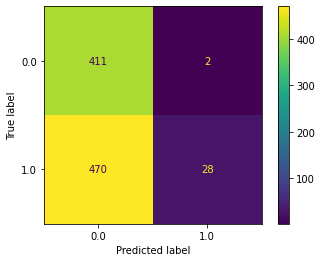

In [12]:
plot_confusion_matrix(model_b, X_test, y_test_b);

In [13]:
imps_b = permutation_importance(model_b, 
                              X_test, 
                              y_test_b, 
                              scoring='precision', random_state=42, n_repeats=10)

imps_b_sorted = pd.Series(imps_b['importances_mean'], index=X.columns).sort_values(ascending=False)

In [14]:
#### SMALL BIZ MODEL (parameter values from search in build_2_model_tuning.ipynb)

model_s = XGBClassifier(
    random_state=42,
    max_depth=2,
    learning_rate=0.10851005231263576,
    scale_pos_weight=0.12516855664882756,
    subsample=0.5232677810835143
)
model_s.fit(X_train, y_train_s)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.10851005231263576, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.12516855664882756,
              subsample=0.5232677810835143, tree_method='exact',
              validate_parameters=1, verbosity=None)

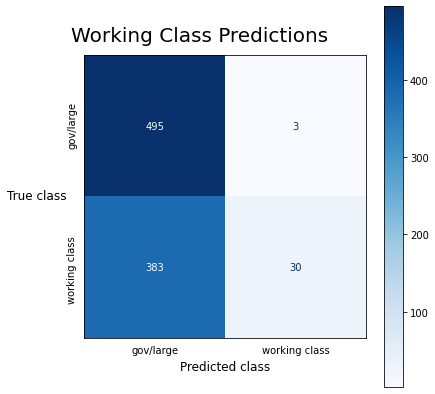

In [15]:
fig, ax = plt.subplots(figsize=[7,7])
# fig.set_facecolor('white')

plot_confusion_matrix(model_s, X_test, y_test_s, ax=ax, cmap='Blues');

ax.set_xticklabels(['gov/large','working class'])
ax.set_yticks([-.15,.8])
ax.tick_params(axis='both', color='white')
ax.set_yticklabels(['gov/large','working class'], rotation=90)

ax.set_ylabel('True class', rotation=0, labelpad=30, fontsize=12, y=.48)
ax.set_xlabel('Predicted class', labelpad=5, fontsize=12)

ax.set_title('Working Class Predictions', fontsize=20, x=.41, y=1.03)
plt.subplots_adjust(left=.2)


plt.savefig('conf.png', dpi=120)
plt.show()

In [16]:
imps_s = permutation_importance(model_s, 
                              X_test, 
                              y_test_s, 
                              scoring='precision', random_state=42, n_repeats=10)

imps_s_sorted = pd.Series(imps_s['importances_mean'], index=X.columns).sort_values(ascending=False)

In [17]:
predictions = pd.DataFrame({'pred_s':model_s.predict(X_test),
                            'pred_b':model_b.predict(X_test)}, index=X_test.index)

In [18]:
op_w_pred = X.merge(predictions, left_index=True, right_index=True)
all_data_w_pred = AB_demo.merge(op_w_pred, left_index=True, right_index=True)

In [19]:
all_data_w_pred.head(3)

,country,urb/rur,age,sex,education,years_edu,work?,occupation,mar_status,spouse_job,housing,car,computer,income,household_income,participate,why_par,why_not_par,q6012,q6013,q6014,q6041,q6043,q6045,q6051,q6052,q6053,q6054,q6055,q6056,q605b1,q605b2,q6061,q6062,q6063,q6064,q6065,q6066,q6071,q6072,q6073,q6074,q6076,q6082,q6087,q6101,q6105,q6106,q810a,q812a1,q812a2,q812a3,q812a4,q812a5,q812a6,q812a7,q812a8,pred_s,pred_b
45,Algeria,Rural,42.0,Female,BA,16.0,Yes,Private sector employee,Married,Government employee,Owned,Yes,Yes,50000.0,100000.0,Refuse,NaN,NaN,2.0,-1.0,-1.0,-2.0,-1.0,-1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-1.0,1.0,1.0,1.0,1.0,2.0,-1.0,-1.0,1.0,-2.0,-2.0,-1.0,-1.0,-1.0,-1.0,2.0,2.0,0.0,0.0
82,Algeria,Urban,36.0,Male,Prepartory/Basic,8.0,Yes,Agricultural worker/Owner of a farm,Bachelor,NaN,Owned,Yes,Yes,37000.0,80000.0,"No, I did not",NaN,I did not care to participate / It was not imp...,1.0,1.0,-2.0,-2.0,-2.0,-2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,2.0,2.0,2.0,-1.0,-1.0,2.0,2.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
90,Algeria,Urban,19.0,Male,Secondary,12.0,No,A student,Bachelor,NaN,Owned,No,Yes,NaN,47000.0,"No, I did not",NaN,I did not agree on the political changes,2.0,2.0,-2.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,-2.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,-1.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,2.0,0.0,0.0


In [20]:
s_positives = all_data_w_pred[all_data_w_pred['pred_s'] == 1]
b_positives = all_data_w_pred[all_data_w_pred['pred_b'] == 1]

In [21]:
model_s.predict_proba(s_positives.loc[:,'q6012':'q812a8'])[:,1]

array([0.57149804, 0.55407554, 0.69835883, 0.59736   , 0.58286816,
       0.6618438 , 0.547555  , 0.51686287, 0.5256003 , 0.7304546 ,
       0.5909876 , 0.5835842 , 0.5444502 , 0.6579865 , 0.65837485,
       0.6822872 , 0.5794312 , 0.5474493 , 0.6555232 , 0.6553035 ,
       0.66192305, 0.65350544, 0.6717597 , 0.67386293, 0.7078097 ,
       0.5565821 , 0.6624576 , 0.62832016, 0.6116657 , 0.65837485,
       0.5489423 , 0.547998  , 0.6029681 ], dtype=float32)

In [22]:
#### ANALYSIS

In [23]:
pd.DataFrame({'perm_imp':imps_b_sorted,
              'pos_class_mean':b_positives[imps_b_sorted.index].mean()},
             index=imps_b_sorted.index).head()

,perm_imp,pos_class_mean
q6105,0.164127,-1.600000
q812a1,0.082591,1.866667
q6106,0.056897,0.666667
q6052,0.053324,1.533333
q6071,0.051719,-0.500000


In [24]:
pd.DataFrame({'perm_imp':imps_s_sorted,
              'pos_class_mean':s_positives[imps_s_sorted.index].mean()},
             index=imps_s_sorted.index).head(6)

,perm_imp,pos_class_mean
q812a3,0.183344,-2.000000
q6052,0.063441,-2.000000
q812a6,0.035549,-0.757576
q6056,0.030715,-1.909091
q6013,0.029659,-0.848485
q6101,0.028336,0.848485


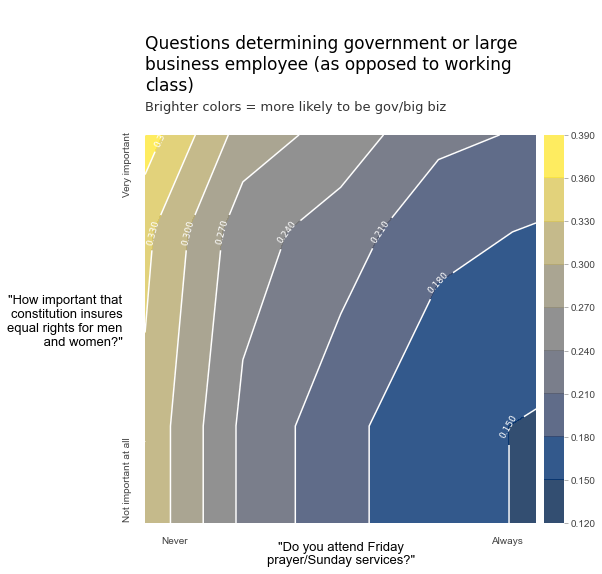

In [25]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

feats = ['q6105', 'q812a1']

interact = pdp_interact(
    model=model_b,
    dataset=X_test,
    model_features=X_test.columns,
    features=feats
)

fig, ax = pdp_interact_plot(interact, 
                            feature_names=feats,
                            plot_params={
                                'title': '',
                                'subtitle': '',
                                'cmap': 'cividis',
                            },
                            plot_type='contour')

ax['pdp_inter_ax'].set_title('Questions determining government or large\nbusiness \
employee (as opposed to working\nclass)', ha='left', fontsize=17, x=0, y=1.1)
ax['pdp_inter_ax'].text(s='Brighter colors = more likely to be gov/big biz', fontsize=13, x=-2, y=2.25, color='#333333')

ax['pdp_inter_ax'].set_xlabel('"Do you attend Friday\nprayer/Sunday services?"', fontsize=13, labelpad=-5)
ax['pdp_inter_ax'].set_ylabel('"How important that\nconstitution insures\n\
equal rights for men\n and women?"', ha='right', fontsize=13, rotation=0, labelpad=0, y=0.45)

ax['pdp_inter_ax'].set_xticks([-1.7,1.7])
ax['pdp_inter_ax'].set_xticklabels(['Never','Always'])
ax['pdp_inter_ax'].set_yticks([-1.15,2])
ax['pdp_inter_ax'].set_yticklabels(['Not important at all','Very important'], rotation=90)
ax['pdp_inter_ax'].tick_params(axis='both', length=10, color='white')

fig.set_facecolor('white')
plt.show()

In [26]:
def simple_bar(feature, title, axis_label, scale_labels, scalefour=False):
    fig, ax = plt.subplots(figsize=[8,5])
    fig.set_facecolor('white')

    w = .4
    colors = ['cornflowerblue', 'darkslategrey']

    b_counts = b_positives[feature].value_counts(normalize=True)
    s_counts = s_positives[feature].value_counts(normalize=True)
    
    def removezero(arr):
        pos_min_one = lambda a: a-1 if a>0 else a
        return np.array([pos_min_one(x) for x in arr])
    
    def makeindex(counts):
        if scalefour:
            ax.set_xticks([-2,1])
            return removezero(np.array(counts.index))
        else:
            ax.set_xticks([-2,2])
            return np.array(counts.index)
    
    ax.bar(x=makeindex(s_counts)-w/2, height=s_counts, width=w, label='Working Class', color=colors[1])
    ax.bar(x=makeindex(b_counts)+w/2, height=b_counts, width=w, label='Gov/Big Business', color=colors[0])

    ax.set_xticklabels(scale_labels)
    ax.set_xlabel(axis_label, fontsize=12)
    ax.tick_params(axis='x', color='white')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_title(title, ha='left', x=0, y=1.03, fontsize=15)
    ax.legend()

    plt.savefig('better.png', dpi=120)
    plt.show()

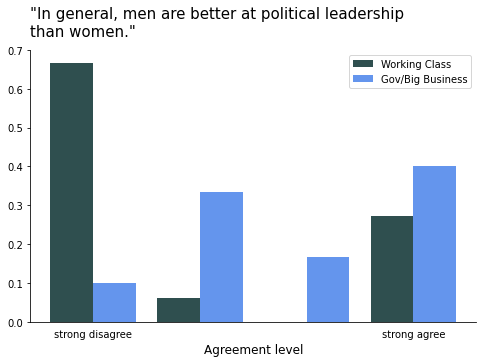

In [27]:
simple_bar('q6013',
           '"In general, men are better at political leadership\nthan women."',
           'Agreement level',
           ['strong disagree','strong agree'],
           scalefour=True)

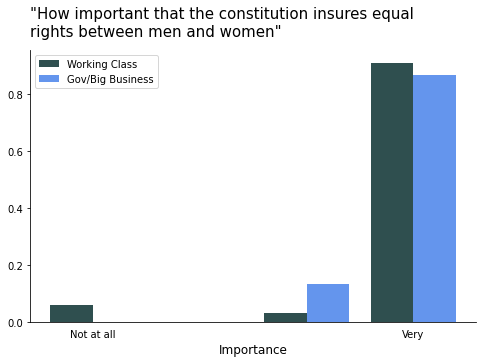

In [28]:
simple_bar('q812a1',
           '"How important that the constitution insures equal\nrights between men and women"',
           'Importance',
           ['Not at all','Very'],
           scalefour=True)

In [29]:
s_positives['sex'].value_counts(normalize=True)

Male      0.606061
Female    0.393939
Name: sex, dtype: float64

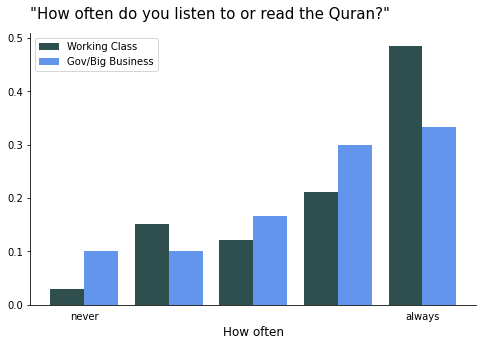

In [30]:
simple_bar('q6106',
           '"How often do you listen to or read the Quran?"',
           'How often',
           ['never','always'])

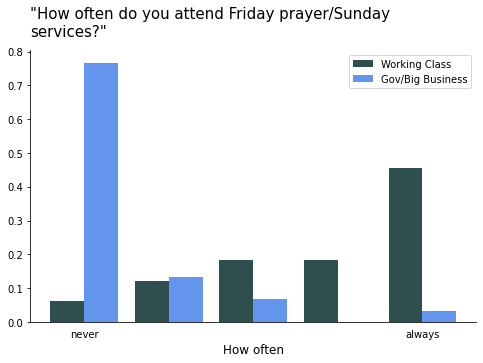

In [31]:
simple_bar('q6105',
           '"How often do you attend Friday prayer/Sunday\nservices?"',
           'How often',
           ['never','always'])

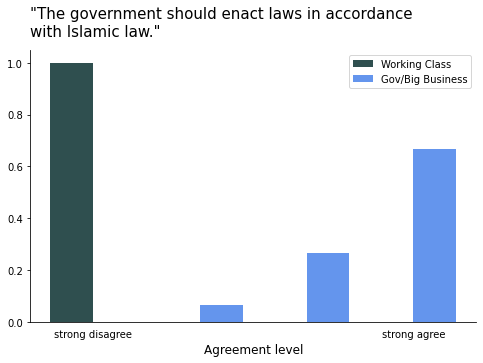

In [32]:
simple_bar('q6052',
           '"The government should enact laws in accordance\nwith Islamic law."',
           'Agreement level',
           ['strong disagree','strong agree'],
           scalefour=True)